## Random Forest Implementation on scaled reduced dataset with t-SNE

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [4]:
df_tsne = pd.read_csv('../../DimensionalityReductionData/t-SNE.csv')

Keep only the 'averageRating' column and join with Dimension 1 & Dimension 2 from t-SNE

In [5]:
df_scaled = df_scaled[['averageRating']]
df_scaled['Dim1'] = df_tsne['Dimension 1']
df_scaled['Dim2'] = df_tsne['Dimension 2']

In [6]:
df_scaled.head()

,averageRating,Dim1,Dim2
0,1,12.275841,-38.495010
1,0,-32.319275,-62.973427
2,1,-77.908150,-10.463196
3,0,-3.411618,-3.128705
4,0,0.957163,-16.427937


Take sample for (initial) tests

In [7]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

In [9]:
X_train.head()

,Dim1,Dim2
2444,2.924084,-93.959280
493,-1.810255,-9.950292
10944,-68.369850,-46.016250
5898,55.612217,-48.116825
5049,71.688160,48.151802


Save and print metrics

In [10]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.9986675549633578
F1 score: [0.99871465 0.99861687]


## Grid Search CV - 1

In [12]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [13]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                                params  mean_test_score
259  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.996502
151  {'bootstrap': False, 'max_depth': None, 'min_s...         0.996502
147  {'bootstrap': False, 'max_depth': None, 'min_s...         0.996418
223  {'bootstrap': False, 'max_depth': 20, 'min_sam...         0.996418
255  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.996418
219  {'bootstrap': False, 'max_depth': 20, 'min_sam...         0.996418
150  {'bootstrap': False, 'max_depth': None, 'min_s...         0.996335
258  {'bootstrap': False, 'max_depth': 30, 'min_sam...         0.996335
3    {'bootstrap': True, 'max_depth': None, 'min_sa...         0.996252
111  {'bootstrap': True, 'max_depth': 30, 'min_samp...         0.996252


Metrics for RF-tSNE-GS-CV1:
Accuracy: 0.9993
Weighted F1: 0.9993
Weighted Precision: 0.9993
Weighted Recall: 0.9993
Macro-Averaged Precision: 0.9993
Macro-Averaged Recall: 0.9993
F1: [0.99935733 0.99930844]
Precision: [0.99935733 0.99930844]
classification report
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1556
     Class 1       1.00      1.00      1.00      1446

    accuracy                           1.00      3002
   macro avg       1.00      1.00      1.00      3002
weighted avg       1.00      1.00      1.00      3002

Confusion Matrix


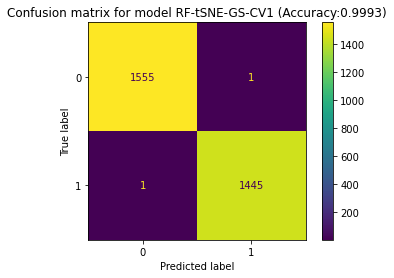

In [14]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-tSNE-GS-CV1', y_test, predictions)

In [15]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9993337774816788
Parameters from place:  1   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9993337774816788
Parameters from place:  2   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9990006662225184
Parameters from place:  3   {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9993337774816788
Parameters from place:  4   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.9990006662225184
Parameters from place:  5   {'bootstrap': False, 'max_depth': 20, 'min_

In [16]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [17]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.9993337774816788
{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [18]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  1   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  2   {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  3   {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  4   {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 1.0
Parameters from place:  5   {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for

In [19]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.9990004164931279
Accuracy for max depth : 13   0.9981674302374011
Accuracy for max depth : 12   0.9955851728446481
Accuracy for max depth : 11   0.9915035401915868
Accuracy for max depth : 10   0.9847563515201999
Accuracy for max depth : 9   0.9726780508121616
Accuracy for max depth : 8   0.9511037067888379
Accuracy for max depth : 7   0.9211995002082466
Accuracy for max depth : 6   0.8773011245314453
Accuracy for max depth : 5   0.8304872969596002
Accuracy for max depth : 4   0.7973344439816743
Accuracy for max depth : 3   0.7702623906705539
Accuracy for max depth : 2   0.7607663473552686
Accuracy for max depth : 1   0.7058725531028738


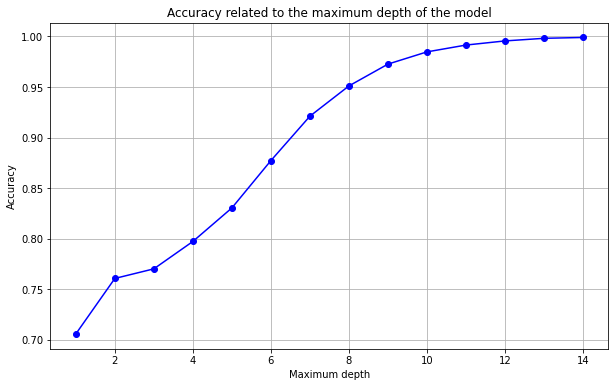

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [21]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=random_state_fit)
  

  model = RandomForestClassifier(random_state=seed, **best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.9993337774816788
0.9980013324450366
0.9993337774816788
0.9973351099267155
0.997001998667555
0.9976682211858761
0.9973351099267155
0.9980013324450366
0.9980013324450366
0.9983344437041972
0.9980013324450366
0.9973351099267155
0.9976682211858761
0.9973351099267155
0.997001998667555
0.9980013324450366
0.9973351099267155
0.9980013324450366
0.9973351099267155
0.9986675549633578
0.9973351099267155
0.9980013324450366
0.9966688874083944
0.997001998667555
0.9983344437041972
0.9963357761492339
0.9993337774816788
0.9986675549633578
0.9973351099267155
0.9986675549633578
0.9973351099267155
0.9983344437041972
0.9980013324450366
0.9980013324450366
0.9983344437041972
0.9966688874083944
0.997001998667555
0.9973351099267155
0.9960026648900733
0.9976682211858761
0.9980013324450366
0.9986675549633578
0.9980013324450366
0.9980013324450366
0.997001998667555
0.9983344437041972
0.9976682211858761
0.997001998667555
0.9966688874083944
0.9986675549633578
0.9983344437041972
0.9986675549633578
0.9960026648900733

In [ ]:
calculate_metrics('RF-tSNE-Shuffled_best', y_best_predictions, best_predictions)